In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import initializers
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 10
IMAGE_SIZE = 28
NUM_CLASSES = 10
NUM_CHANNELS = 1
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_weight_init"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

# Train

In [10]:
models = []
accuracies = []
predictions = []
initializer = ["Zero","Ones","Random Normal","Random Uniform","Identity","Orthogonal","Glorot Normal","Glorot Uniform"]
for i in range(len(initializer)):

    print(f"Train model {i}")
    print(f"Weight init method: {initializer[i]} ")
    model = FashionMNISTmodel(IMAGE_SIZE,NUM_CLASSES,NUM_CHANNELS)
    
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            if(initializer[i] == "Zero"):
                layer.kernel_initializer = initializers.Zeros()
            elif(initializer[i] == "Ones"):
                layer.kernel_initializer = initializers.Ones()
            elif(initializer[i] == "Random Normal"):
                layer.kernel_initializer = initializers.RandomNormal()
            elif(initializer[i] == "Random Unifrom"):
                layer.kernel_initializer = initializers.RandomUniform()
            elif(initializer[i] == "Identity"):
                layer.kernel_initializer = initializers.Identity()
            elif(initializer[i] == "Orthogonal"):
                layer.kernel_initializer = initializers.Orthogonal()
            elif(initializer[i] == "Glorot Normal"):
                layer.kernel_initializer = initializers.GlorotNormal()
            elif(initializer[i] == "Glorot Unifrom"):
                layer.kernel_initializer = initializers.GlorotUnifrom()
          
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=0.01, patience=3)
    model.fit(x_train,y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_val,y_val),
              shuffle = True,
              callbacks=[es])
    models.append(model)
    y_prob = model.predict(x_test) 
    predictions.append(y_prob.argmax(axis=-1))
    acc = model.evaluate(x_test,y_testc)[1]
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")


Train model 0
Weight init method: Zero 
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 93us/step - loss: 2.1487 - accuracy: 0.2455 - val_loss: 2.1680 - val_accuracy: 0.2932
Epoch 2/10
 3456/48000 [=>............................] - ETA: 2s - loss: 1.9920 - accuracy: 0.3571

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


48000/48000 [==============================] - 3s 55us/step - loss: 1.9000 - accuracy: 0.3768 - val_loss: 1.8021 - val_accuracy: 0.4241
Epoch 3/10
48000/48000 [==============================] - 3s 55us/step - loss: 1.7052 - accuracy: 0.4329 - val_loss: 1.6046 - val_accuracy: 0.4569
Epoch 4/10
48000/48000 [==============================] - 3s 56us/step - loss: 1.5538 - accuracy: 0.4793 - val_loss: 1.4684 - val_accuracy: 0.5028
Epoch 5/10
48000/48000 [==============================] - 3s 55us/step - loss: 1.4303 - accuracy: 0.5273 - val_loss: 1.3604 - val_accuracy: 0.5491
Epoch 6/10
48000/48000 [==============================] - 3s 55us/step - loss: 1.3392 - accuracy: 0.5650 - val_loss: 1.2798 - val_accuracy: 0.5813
Epoch 7/10
48000/48000 [==============================] - 3s 56us/step - loss: 1.2675 - accuracy: 0.5877 - val_loss: 1.2177 - val_accuracy: 0.5991
Epoch 8/10
48000/48000 [==============================] - 3s 56us/step - loss: 1.2105 - accuracy: 0.6040 - val_loss: 1.1671 - val

# Results

# Accuracy

In [11]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df["weight_init_method"] = initializer
display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,weight_init_method
0,0.6318,Zero
1,0.6315,Ones
2,0.6441,Random Normal
3,0.6165,Random Uniform
4,0.6557,Identity
5,0.6386,Orthogonal
6,0.6308,Glorot Normal
7,0.6314,Glorot Uniform


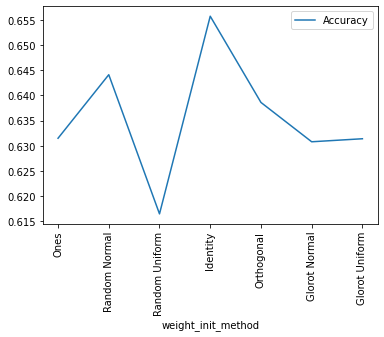

In [12]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="weight_init_method", y="Accuracy",rot = 90)

plt.show()


In [14]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 8/8 [00:00<00:00, 257.44it/s]


## Correlation between models

In [15]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df.columns = initializer
correlation_matrix_df.index = initializer
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,Zero,Ones,Random Normal,Random Uniform,Identity,Orthogonal,Glorot Normal,Glorot Uniform
Zero,NaN,0.700217,0.685318,0.675400,0.699178,0.693255,0.740508,0.689705
Ones,0.700217,NaN,0.673483,0.687585,0.682902,0.747903,0.720576,0.729075
Random Normal,0.685318,0.673483,NaN,0.721691,0.690860,0.672914,0.689018,0.702297
Random Uniform,0.675400,0.687585,0.721691,NaN,0.654721,0.677691,0.695972,0.747492
Identity,0.699178,0.682902,0.690860,0.654721,NaN,0.673224,0.689868,0.654792
Orthogonal,0.693255,0.747903,0.672914,0.677691,0.673224,NaN,0.737458,0.687297
Glorot Normal,0.740508,0.720576,0.689018,0.695972,0.689868,0.737458,NaN,0.698471
Glorot Uniform,0.689705,0.729075,0.702297,0.747492,0.654792,0.687297,0.698471,NaN


Average correlation: 0.6971025480855594
